# Week 16 Report

---

## Assignment 9 fixes (z-prediction)

We addressed the feedback from Assignment 9 as follows:

* **Non-sequential modelling** – Rather than using a CNN or RNN to predict z-coordinates over time, we now employ a fully connected (dense) model that predicts the z-coordinate for each frame independently. This change, as suggested, improved performance.
* **Target scaling** – The target (z) values are now scaled.
* **Hyperparameter search** – We use `sklearn.model_selection.GridSearchCV` for systematic hyperparameter tuning rather than implementing grid search manually.
* **Programmatic output** – The code now prints results automatically instead of leaving them only in Markdown.
* **Parameter persistence** – The best hyper-parameters found by Grid Search are saved to disk.
* **Business-oriented reporting** – Results are framed in a business context: we report mean absolute error (MAE) in centimetres, joint by joint, and include a comparative plot. Stakeholders can see that the average z-coordinate error is roughly 1 cm.

Below are the updated code and results.

### 0. Reproducibility

In [7]:
from __future__ import annotations
from pathlib import Path
import os, random, warnings
import numpy as np
import pandas as pd


os.environ.update(
    PYTHONHASHSEED="42",
    TF_DETERMINISTIC_OPS="1",
    TF_CUDNN_DETERMINISM="1",
)
random.seed(42)
np.random.seed(42)

### 1. Hyper-parameters

In [8]:
DIR_DATA    = Path("../ML/data/kinect_good_preprocessed")
USE_SCALER  = True
PATIENCE    = 10
MAX_EPOCHS  = 200

param_grid = {                              
    "model__units":         [256],
    "model__n_hidden":      [12],
    "model__dropout":       [0.05],
    "model__learning_rate": [3e-4],
    "batch_size":           [128],
}

### 2. Load data

In [9]:
def split_xyz_cols(df: pd.DataFrame) -> tuple[list[str], list[str]]:
    """Return ([all _x, _y], [all _z]) columns in consistent joint order."""
    xyz_cols = [c for c in df.columns if c not in ("FrameNo",)]
    joints   = sorted({c.rsplit("_", 1)[0] for c in xyz_cols})
    xy_cols  = [f"{j}_{a}" for j in joints for a in ("x", "y")]
    z_cols   = [f"{j}_z"   for j in joints]
    missing  = [c for c in xy_cols + z_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Columns missing in CSV: {missing[:6]} …")
    return xy_cols, z_cols

X_chunks, y_chunks = [], []

for csv_path in sorted(DIR_DATA.glob("*.csv")):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    xy_cols, z_cols = split_xyz_cols(df)

    X_chunks.append(df[xy_cols].to_numpy(dtype=np.float32))
    y_chunks.append(df[z_cols].to_numpy(dtype=np.float32))
    print(f"✅ {csv_path.name:<30}  frames: {len(df)}")

if not X_chunks:
    raise RuntimeError("No CSV files found in ML/data/frames")

X = np.concatenate(X_chunks, axis=0)
y = np.concatenate(y_chunks, axis=0)
print(f"\n🎯 Final shapes  X:{X.shape}  y:{y.shape}")

✅ A100_kinect.csv                 frames: 163
✅ A101_kinect.csv                 frames: 229
✅ A102_kinect.csv                 frames: 206
✅ A103_kinect.csv                 frames: 168
✅ A104_kinect.csv                 frames: 153
✅ A105_kinect.csv                 frames: 146
✅ A106_kinect.csv                 frames: 159
✅ A108_kinect.csv                 frames: 154
✅ A109_kinect.csv                 frames: 100
✅ A10_kinect.csv                  frames: 161
✅ A110_kinect.csv                 frames: 113
✅ A111_kinect.csv                 frames: 200
✅ A112_kinect.csv                 frames: 63
✅ A113_kinect.csv                 frames: 75
✅ A114_kinect.csv                 frames: 61
✅ A115_kinect.csv                 frames: 104
✅ A116_kinect.csv                 frames: 214
✅ A117_kinect.csv                 frames: 216
✅ A118_kinect.csv                 frames: 130
✅ A119_kinect.csv                 frames: 167
✅ A11_kinect.csv                  frames: 218
✅ A120_kinect.csv                 fra

### 3. Split & Scale

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42
)

if USE_SCALER:
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)
    X_train, y_train = X_scaler.transform(X_train), y_scaler.transform(y_train)
    X_test, y_test = X_scaler.transform(X_test), y_scaler.transform(y_test)
else:
    X_scaler = y_scaler = None

### 4. Model Factory

In [11]:
import tensorflow as tf, keras
tf.random.set_seed(42)
warnings.filterwarnings("ignore", category=UserWarning)

def build_model(
    meta,
    units=128,
    n_hidden=4,
    dropout=0.10,
    learning_rate=1e-3,
    l2=1e-4,
):
    """Return a depth-regression MLP.
    `meta` is auto-injected by SciKeras and includes the data shapes."""
    input_dim  = meta["n_features_in_"]   # 26  (2 × joints)
    target_dim = meta["n_outputs_"]       # 13  (z for each joint)

    reg = keras.regularizers.L2(l2)
    inputs = keras.layers.Input(shape=(input_dim,))
    x = inputs
    for _ in range(n_hidden):
        x = keras.layers.Dense(units, kernel_regularizer=reg)(x)
        x = keras.layers.PReLU()(x)
        x = keras.layers.Dropout(dropout)(x)
    outputs = keras.layers.Dense(target_dim)(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss="mse",
        metrics=["mae"],
    )
    return model

### 5. Grid Search

In [12]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import make_scorer, mean_squared_error
neg_mse = make_scorer(mean_squared_error, greater_is_better=False)

reg = KerasRegressor(
    model=build_model,
    epochs=MAX_EPOCHS,
    verbose=0,
    random_state=42,
    shuffle=True,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=PATIENCE, restore_best_weights=True
)
reduce_lr  = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=PATIENCE//2, min_lr=1e-6
)

grid = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring=neg_mse,
    cv=5,
    refit=True,
    n_jobs=1,
    verbose=10,
)

print(f"\n⏳ GridSearchCV  configs: {len(ParameterGrid(param_grid))}  × 5-fold CV\n")
grid_result = grid.fit(
    X_train, y_train,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
)


⏳ GridSearchCV  configs: 1  × 5-fold CV

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START batch_size=128, model__dropout=0.05, model__learning_rate=0.0003, model__n_hidden=12, model__units=256
[CV 1/5; 1/1] END batch_size=128, model__dropout=0.05, model__learning_rate=0.0003, model__n_hidden=12, model__units=256;, score=-0.014 total time= 7.2min
[CV 2/5; 1/1] START batch_size=128, model__dropout=0.05, model__learning_rate=0.0003, model__n_hidden=12, model__units=256
[CV 2/5; 1/1] END batch_size=128, model__dropout=0.05, model__learning_rate=0.0003, model__n_hidden=12, model__units=256;, score=-0.016 total time= 7.6min
[CV 3/5; 1/1] START batch_size=128, model__dropout=0.05, model__learning_rate=0.0003, model__n_hidden=12, model__units=256
[CV 3/5; 1/1] END batch_size=128, model__dropout=0.05, model__learning_rate=0.0003, model__n_hidden=12, model__units=256;, score=-0.015 total time= 8.0min
[CV 4/5; 1/1] START batch_size=128, model__dropout=0.05, model__l

### 6. Evaluation


🏆 Best hyper-parameters:
   • batch_size        : 128
   • model__dropout    : 0.05
   • model__learning_rate: 0.0003
   • model__n_hidden   : 12
   • model__units      : 256
Best CV MSE (scaled): 0.015626680105924606

📊 Test MAE (mean over all joints): 0.89 cm


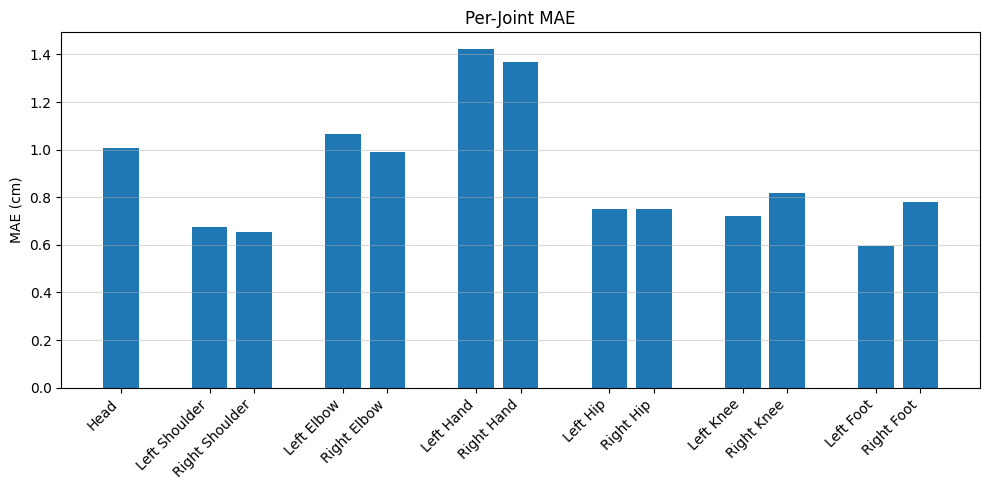

In [13]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt


print("\n🏆 Best hyper-parameters:")
for k, v in grid_result.best_params_.items():
    print(f"   • {k:18s}: {v}")
print("Best CV MSE (scaled):", -grid_result.best_score_)

best_model = grid_result.best_estimator_.model_

y_pred_scaled = best_model.predict(X_test, verbose=0)
y_test_orig   = y_scaler.inverse_transform(y_test) if y_scaler else y_test
y_pred_orig   = y_scaler.inverse_transform(y_pred_scaled) if y_scaler else y_pred_scaled

# ─── 1) Compute per‐joint MAE in meters (raw values) ───────────────────────────────
test_MAEs = mean_absolute_error(y_test_orig, y_pred_orig, multioutput="raw_values")

# Convert to centimeters
joint_mae_cm = test_MAEs * 100

# ─── 2) Define joint names in the exact order your model outputs them (without "_z") ─
joint_names = [
    "head",
    "left_elbow",
    "left_foot",
    "left_hand",
    "left_hip",
    "left_knee",
    "left_shoulder",
    "right_elbow",
    "right_foot",
    "right_hand",
    "right_hip",
    "right_knee",
    "right_shoulder",
]

# ─── 3) Print overall MAE (mean over all joints) in cm ────────────────────────────
overall_mae_cm = joint_mae_cm.mean()
print(f"\n📊 Test MAE (mean over all joints): {overall_mae_cm:.2f} cm")


# ─── 4) Define “groups” for plotting ──────────────────────────────────────────────
groups = [
    ("HEAD",        ["head"]),  # singleton
    ("SHOULDERS",   ["left_shoulder", "right_shoulder"]),
    ("ELBOWS",      ["left_elbow",    "right_elbow"]),
    ("HANDS",       ["left_hand",     "right_hand"]),
    ("HIPS",        ["left_hip",      "right_hip"]),
    ("KNEES",       ["left_knee",     "right_knee"]),
    ("FEET",        ["left_foot",     "right_foot"]),
]

# ─── 5) Build x‐positions, heights, and labels with spacing between groups ──────
xs = []
heights = []
xtick_labels = []

current_x = 0
gap = 1  # how many “units” of space to leave after each group

for group_label, joint_list in groups:
    # Within each group, place each joint at current_x, current_x+1, ...
    for joint_key in joint_list:
        xs.append(current_x)
        heights.append(joint_mae_cm[joint_names.index(joint_key)])
        # Turn names like "left_shoulder" → "Left Shoulder"
        pretty_name = joint_key.replace("_", " ").title()
        xtick_labels.append(pretty_name)
        current_x += 1
    # After finishing one group, leave a blank “gap” before the next block:
    current_x += gap

# ─── 6) Plot bar chart ─────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 5))
plt.bar(xs, heights, width=0.8)
plt.ylabel("MAE (cm)")
plt.title("Per-Joint MAE")

# Apply the custom x‐ticks and labels:
plt.xticks(xs, xtick_labels, rotation=45, ha="right")

plt.grid(axis='y', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

### 7. Saving

In [15]:
from joblib import dump
best_model.save("../ML/models/depth_model.keras")
dump(grid_result.best_params_, "../ML/models/depth_best_params.pkl")
if X_scaler is not None:
    dump(X_scaler, "../ML/models/depth_X_scaler.pkl")
    dump(y_scaler, "../ML/models/depth_y_scaler.pkl")
else:
    Path("NO_SCALER_USED.txt").touch()

print("\n💾  Model stored in models/depth_model.keras\n")


💾  Model stored in models/depth_model.keras

